<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Project 4:
## In A Heartbeat: Prediction of Heart Disease Risk for Early Detection
---

## 2B. Exploratory Data Analysis - Analysis on Missing Values


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import missingno as msno
import lightgbm
from missforest.missforest import MissForest

# setting displays
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# import dataset
df = pd.read_csv('../data/filtered_data.csv')

### 2B.1 First look at data

In [ ]:
# inspect first 5 rows
print(df.head())

    age  height  weight    bmi  yrssmok  packday  sleep_hours  health_status  phys_health_not_good  mental_health_not_good  last_routine_checkup  visit_dentist_past_year  health_insurance  phy_exercise_past_30_days  stroke  cancer  kidney_disease  colon_sigmoidoscopy  chd_mi  asthma_status  race_ethnicity  sex  education  income  smoker_status  e_cig_smoker  binge_drinker  heavy_drinker
0  80.0     NaN     NaN    NaN      0.0      0.0          8.0            2.0                   1.0                     1.0                   1.0                      9.0               9.0                        2.0     2.0     2.0             2.0                  1.0     2.0            3.0             1.0  2.0        4.0    99.0            4.0           1.0            1.0            1.0
1  80.0    1.60   68.04  26.58      0.0      0.0          6.0            1.0                   1.0                     1.0                   8.0                      9.0               1.0                        2.0     2

In [ ]:
df_shape = df.shape

print(f'{df_shape[0]} rows and {df_shape[1]} columns')

445132 rows and 28 columns


Our target variable is going to be those with heart disease or those that had an heart attack. We will drop all rows with null values associated with our target variable `chd_mi`.

In [ ]:
# Remove rows with null values in target variable
df = df.dropna(subset='chd_mi')

In [ ]:
# check the changed number of rows
df.shape

(440111, 28)

In [ ]:
# final check of dataframe before proceeding
print(df.head())

    age  height  weight    bmi  yrssmok  packday  sleep_hours  health_status  phys_health_not_good  mental_health_not_good  last_routine_checkup  visit_dentist_past_year  health_insurance  phy_exercise_past_30_days  stroke  cancer  kidney_disease  colon_sigmoidoscopy  chd_mi  asthma_status  race_ethnicity  sex  education  income  smoker_status  e_cig_smoker  binge_drinker  heavy_drinker
0  80.0     NaN     NaN    NaN      0.0      0.0          8.0            2.0                   1.0                     1.0                   1.0                      9.0               9.0                        2.0     2.0     2.0             2.0                  1.0     2.0            3.0             1.0  2.0        4.0    99.0            4.0           1.0            1.0            1.0
1  80.0    1.60   68.04  26.58      0.0      0.0          6.0            1.0                   1.0                     1.0                   8.0                      9.0               1.0                        2.0     2

### 2B.2 Responses such as 'Don't know' or 'Refused to answer'

Looking through the dataset, there were responses such as 'Don't know' or 'Refused to answer' which were captured. These do not add value nor meaning to our dataset, hence we will replace these responses with null, with the end goal of imputating these null values.

In [ ]:
# 7: Don't know/ Not sure, 9: Refused
to_replace = [7, 9]

columns_to_replace = ['health_status', 'phys_health_not_good', 'mental_health_not_good', 'last_routine_checkup',
                      'visit_dentist_past_year', 'health_insurance', 'phy_exercise_past_30_days', 'stroke',
                      'cancer', 'kidney_disease', 'colon_sigmoidoscopy', 'asthma_status', 'education',
                      'smoker_status', 'e_cig_smoker', 'yrssmok', 'packday', 'binge_drinker', 'heavy_drinker']

df[columns_to_replace] = df[columns_to_replace].replace(to_replace, np.nan)

In [ ]:
# 77: Don't know/ Not sure, 99: Refused
df['sleep_hours'] = df['sleep_hours'].replace((77, 99), np.nan)
df['race_ethnicity'] = df['race_ethnicity'].replace(9, np.nan)
df['income'] = df['income'].replace((77, 99), np.nan)

### 2B.3 Check for null values

In [ ]:
# To list percentage of null values within each column
count_of_nulls = df.isnull().mean().sort_values(ascending=False)


# Filter out columns with null values more than 5% of entire dataset
print(count_of_nulls[count_of_nulls>0.05])

income           0.213889
binge_drinker    0.113985
heavy_drinker    0.110861
bmi              0.103683
weight           0.093717
yrssmok          0.086528
packday          0.085144
e_cig_smoker     0.079473
smoker_status    0.079007
height           0.063593
dtype: float64



* df.isnull(): This part of the code generates a boolean DataFrame of the same shape as df where True indicates a missing value (NaN) and False indicates a non-missing value.

* .mean(): This function is applied to the boolean DataFrame obtained from df.isnull(). It calculates the mean of each column, treating True values as 1 and False values as 0. This effectively gives the proportion of missing values in each column.
* .sort_values(ascending=False): This function sorts the result of the .mean() calculation in descending order. This means that columns with the highest proportion of missing values will appear first in the resulting Series.

* count_of_nulls = ...: Finally, the sorted Series containing the proportion of missing values in each column is assigned to the variable count_of_nulls.
So, the count_of_nulls variable will contain a Series where the index represents column names, and the values represent the proportion of missing values in each column, sorted from highest to lowest proportion.

Analysis:  
The highest proportion of missing data is from `income` at a sizeable percentage of 20%. This is too large to ignore.  
Other variables that have more than 5% of their data missing pertain mainly to respondents' body measurement, tobacco use and alcohol consumption. We will do a further analysis on the the missing values to see if there is any pattern behind its missingness.

#### 2B.3.1 Visualisation of missing values

We will do an analysis of the missing values to see if there is any pattern behind the missingness. We will use 2 different types of visualisation for this purpose: matrix plot and dendrogram.

Text(0.5, 1.0, 'Matrix Plot of Missing Values')

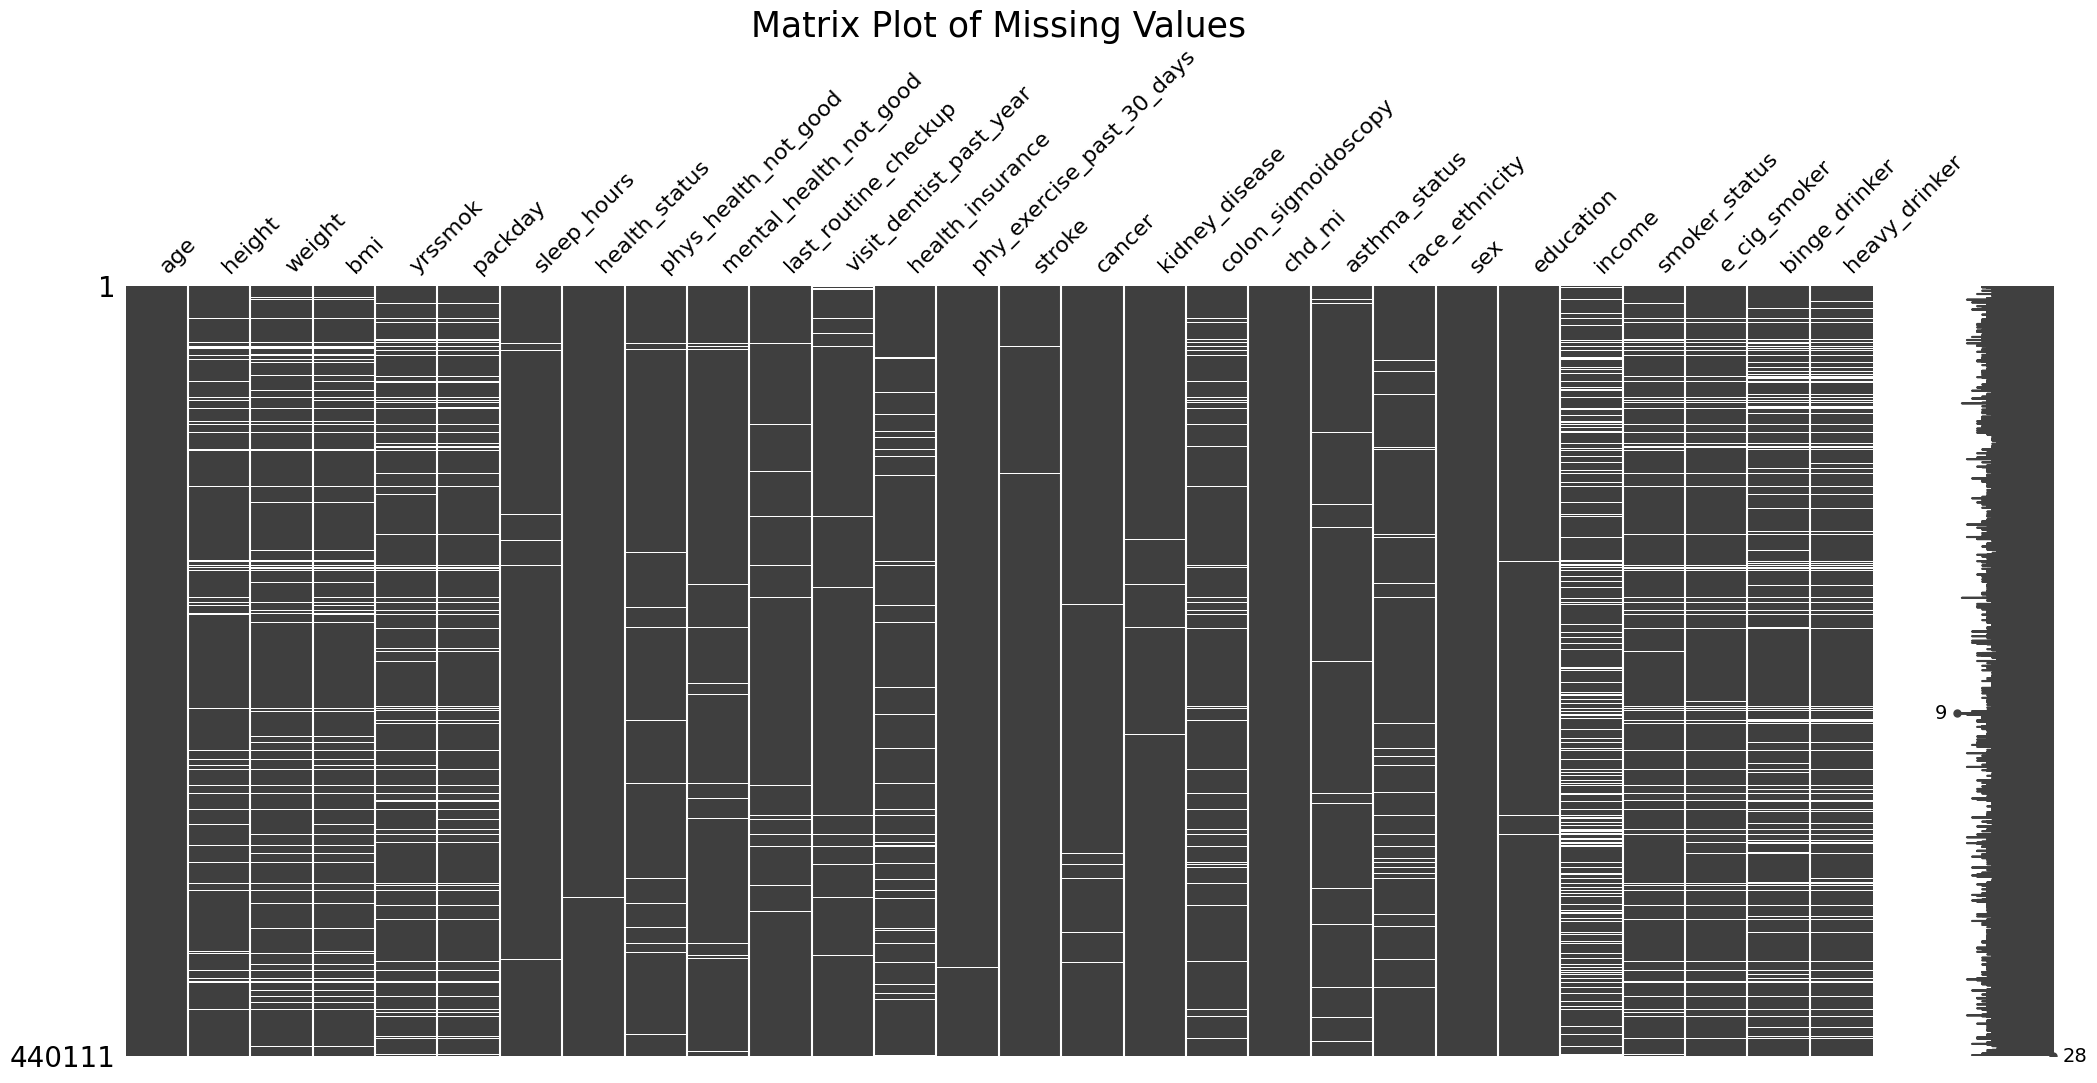

In [ ]:
# Visualise missing values using a matrix plot
msno.matrix(df)
plt.title('Matrix Plot of Missing Values', fontsize=25)

Interpretation:  

In this matrix plot, each white line represents missing observations, and the lines are visualised in the order which they appear in the data set, top to bottom.  
If a white line extends across several columns horizontally, it means that the null value for those column came from the same row/ respondent.

Analysis:  
  
From this plot, we can identify a few variables which have very similar pattern in their missingness. They are:

1. Body measurements: `height`, `weight`, `bmi`,
2. Tobacco use: `yrssmok`, `packday`, `smoker_status`, `e_cig_smoker`, and
3. Alcohol consumption: `binge_drinker` and `heavy_drinker`

These variables are likely to have a close relationship with each other. However, the missingness in `income` appears to be random. We will take a further look by doing the same matrix plot sorted by selected features.

#### 2B.3.2 Matrix plot sorted by age, sex, race and education

Text(0.5, 1.0, 'Matrix Plot of Missing Values Sorted by Age')

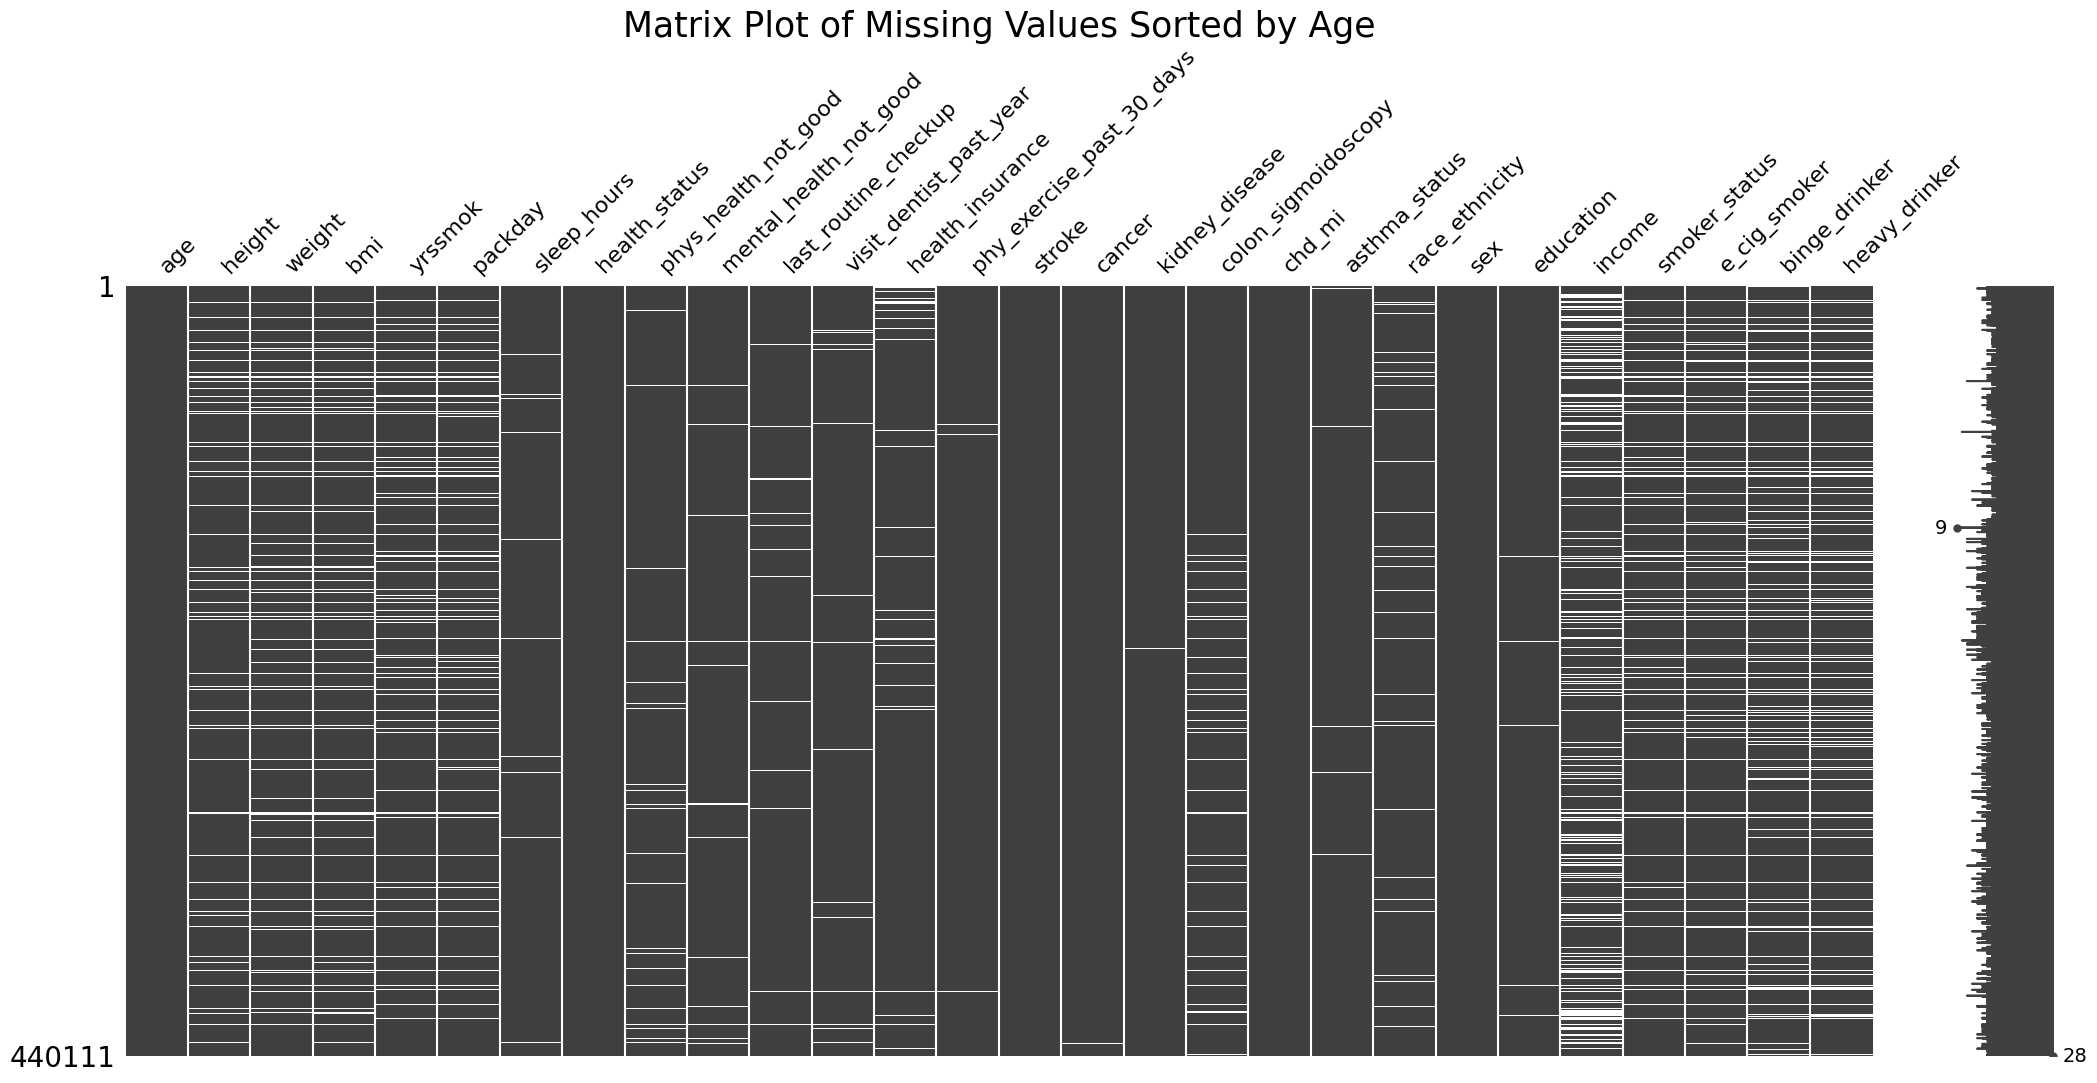

In [ ]:
# Visualise missing values using a matrix plot sorted by age
msno.matrix(df.sort_values('age'))
plt.title('Matrix Plot of Missing Values Sorted by Age', fontsize=25)

Text(0.5, 1.0, 'Matrix Plot of Missing Values Sorted by Sex')

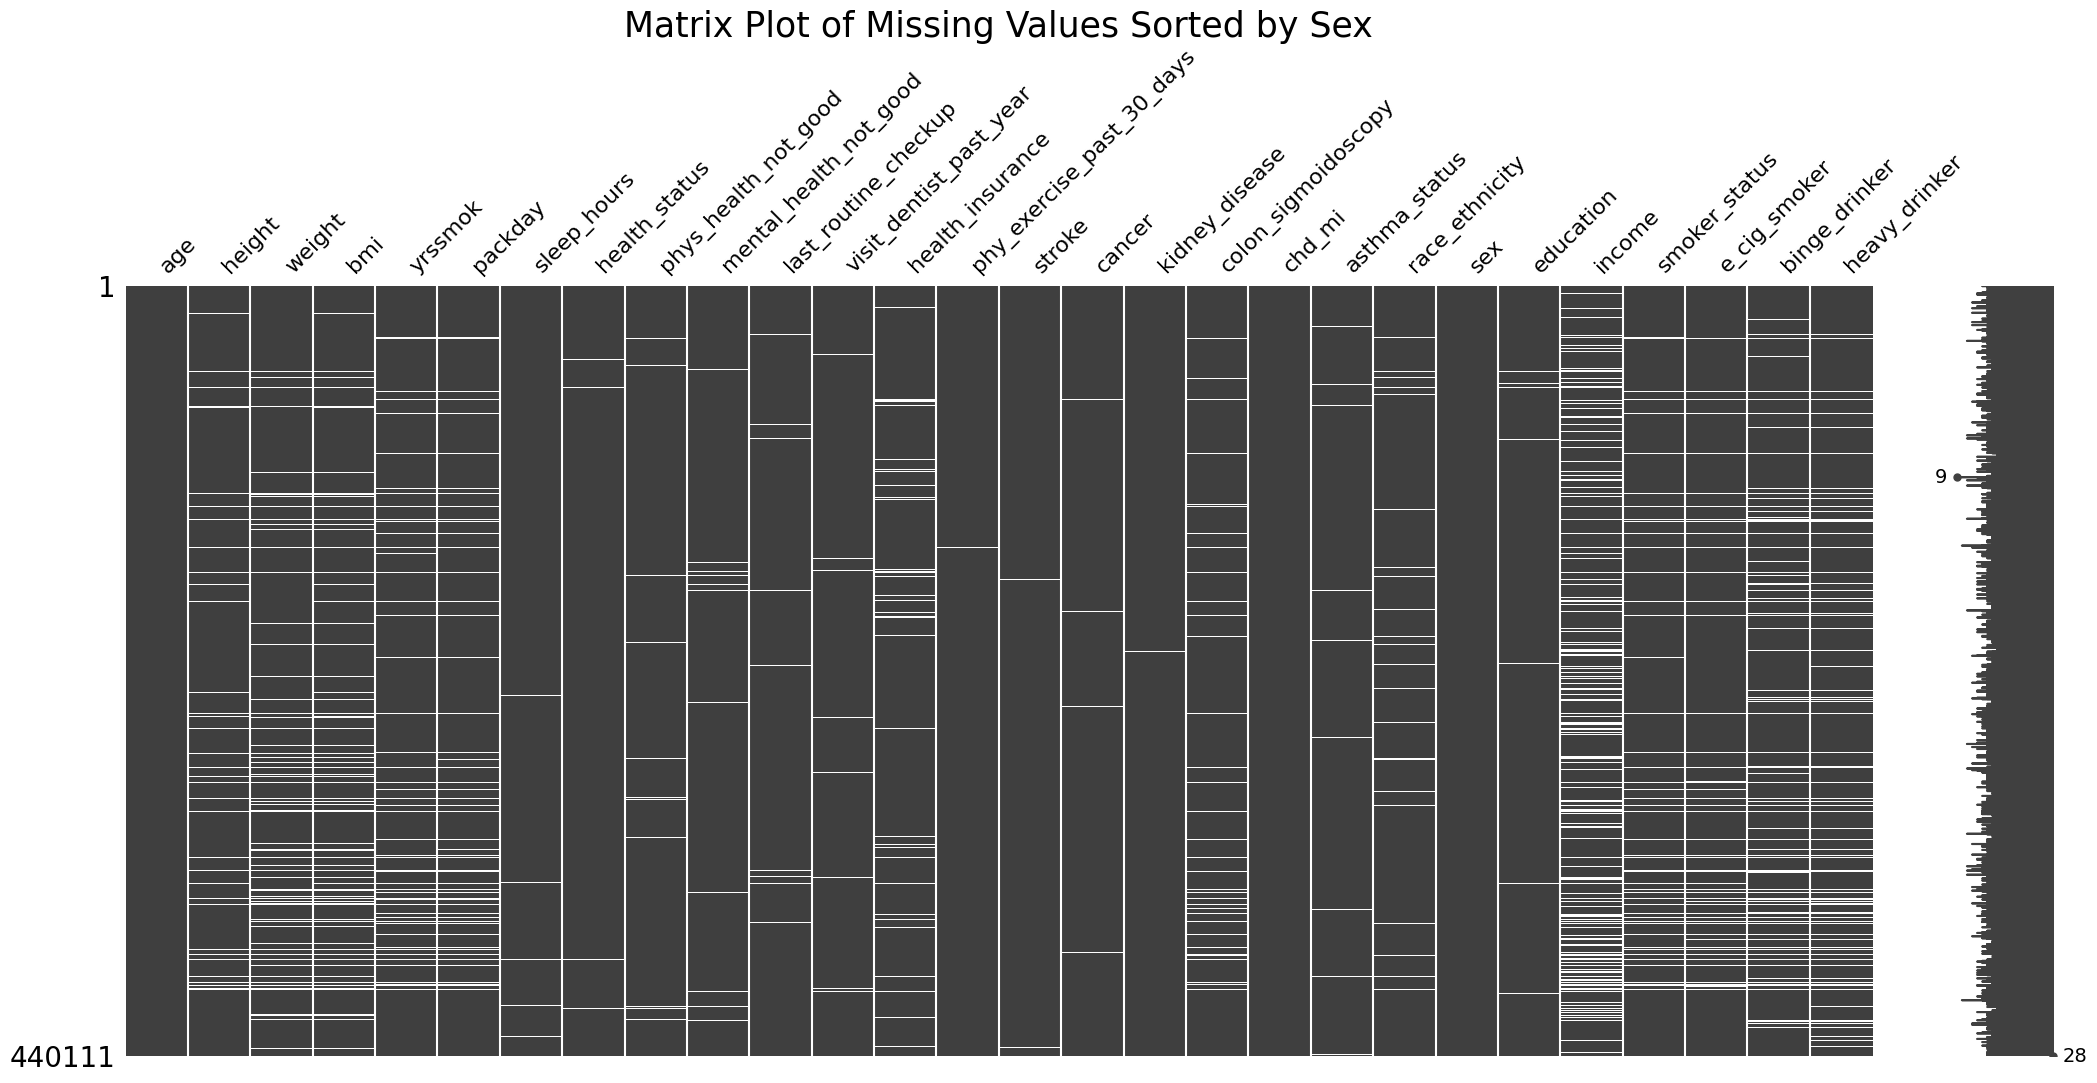

In [ ]:
# Visualise missing values using a matrix plot sorted by sex
msno.matrix(df.sort_values('sex'))
plt.title('Matrix Plot of Missing Values Sorted by Sex', fontsize=25)

Text(0.5, 1.0, 'Matrix Plot of Missing Values Sorted by Race')

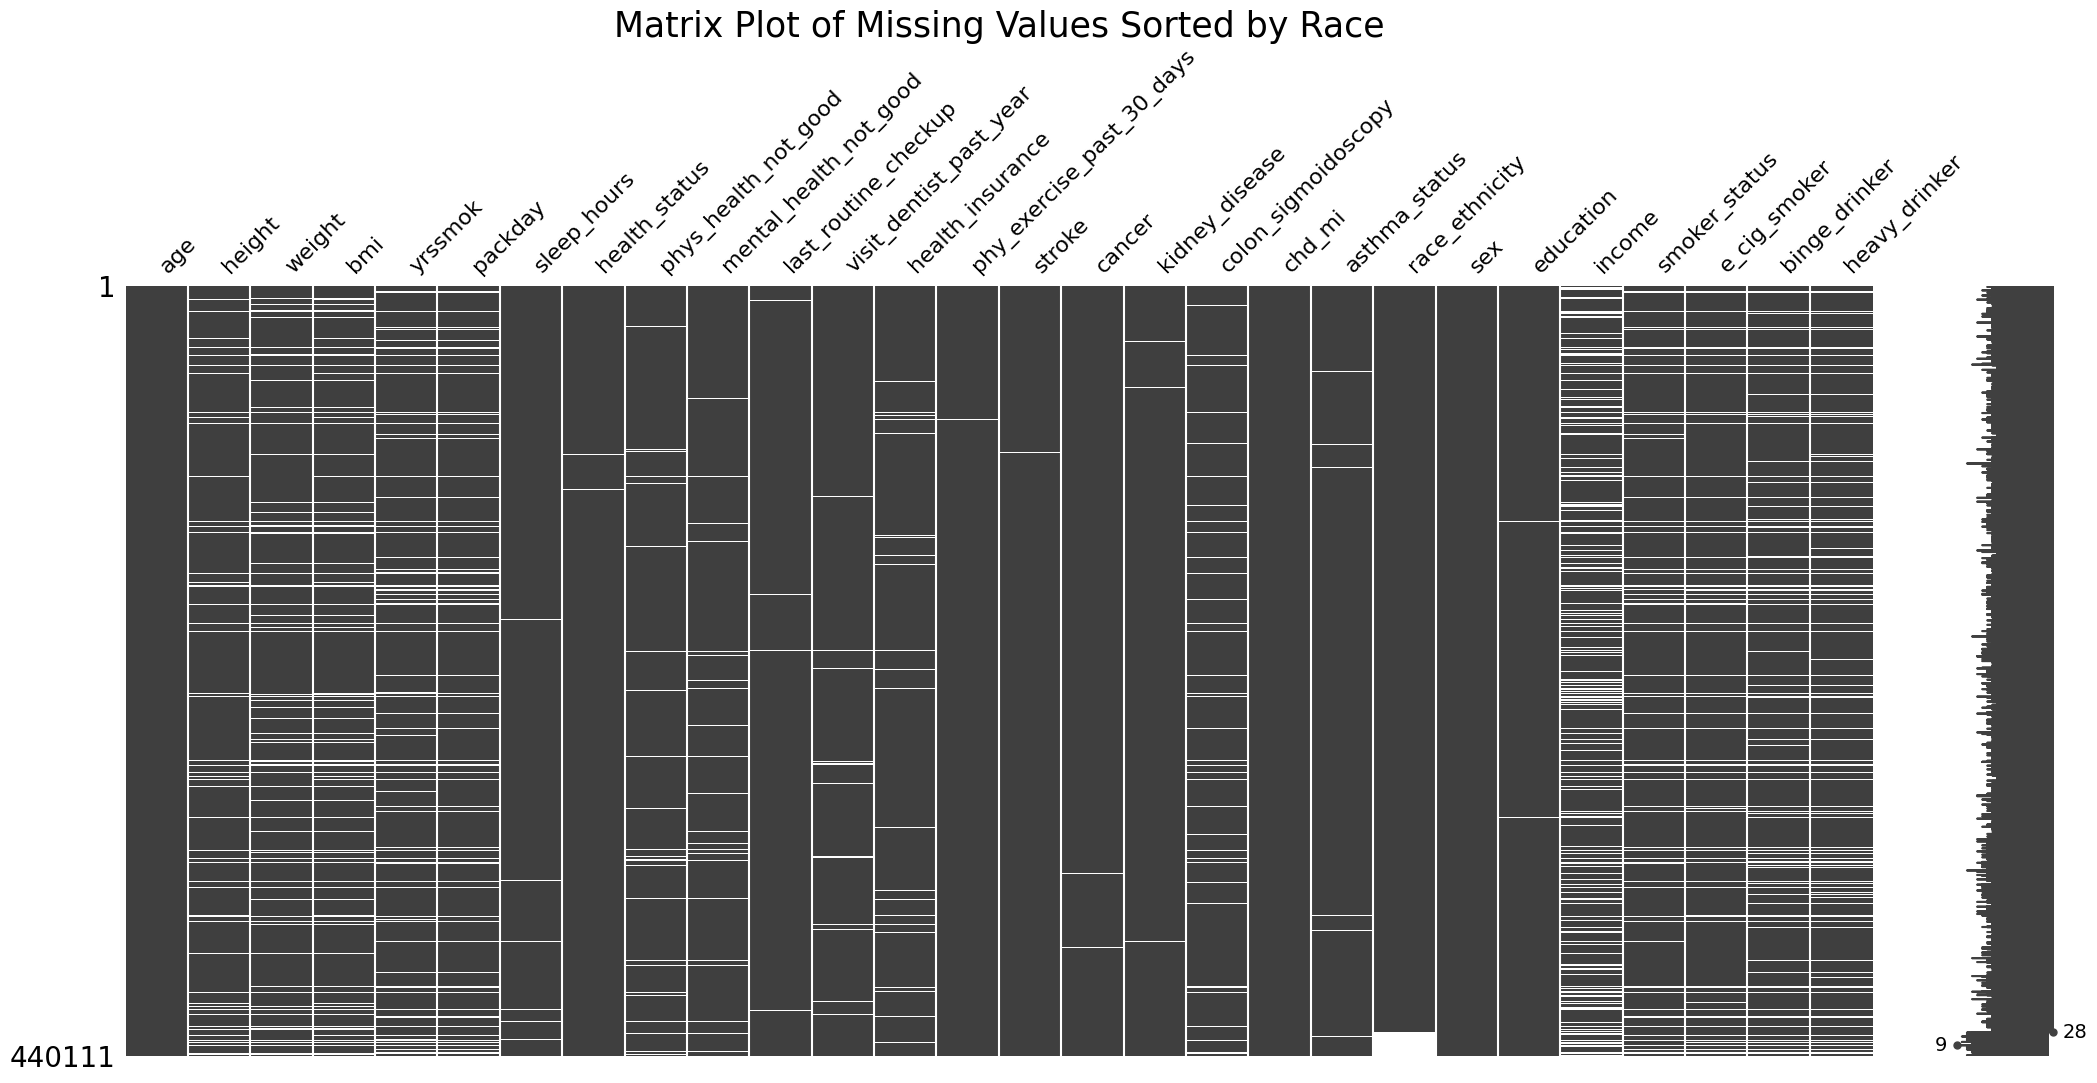

In [ ]:
# Visualise missing values using a matrix plot sorted by race
msno.matrix(df.sort_values('race_ethnicity'))
plt.title('Matrix Plot of Missing Values Sorted by Race', fontsize=25)

Text(0.5, 1.0, 'Matrix Plot of Missing Values Sorted by Education')

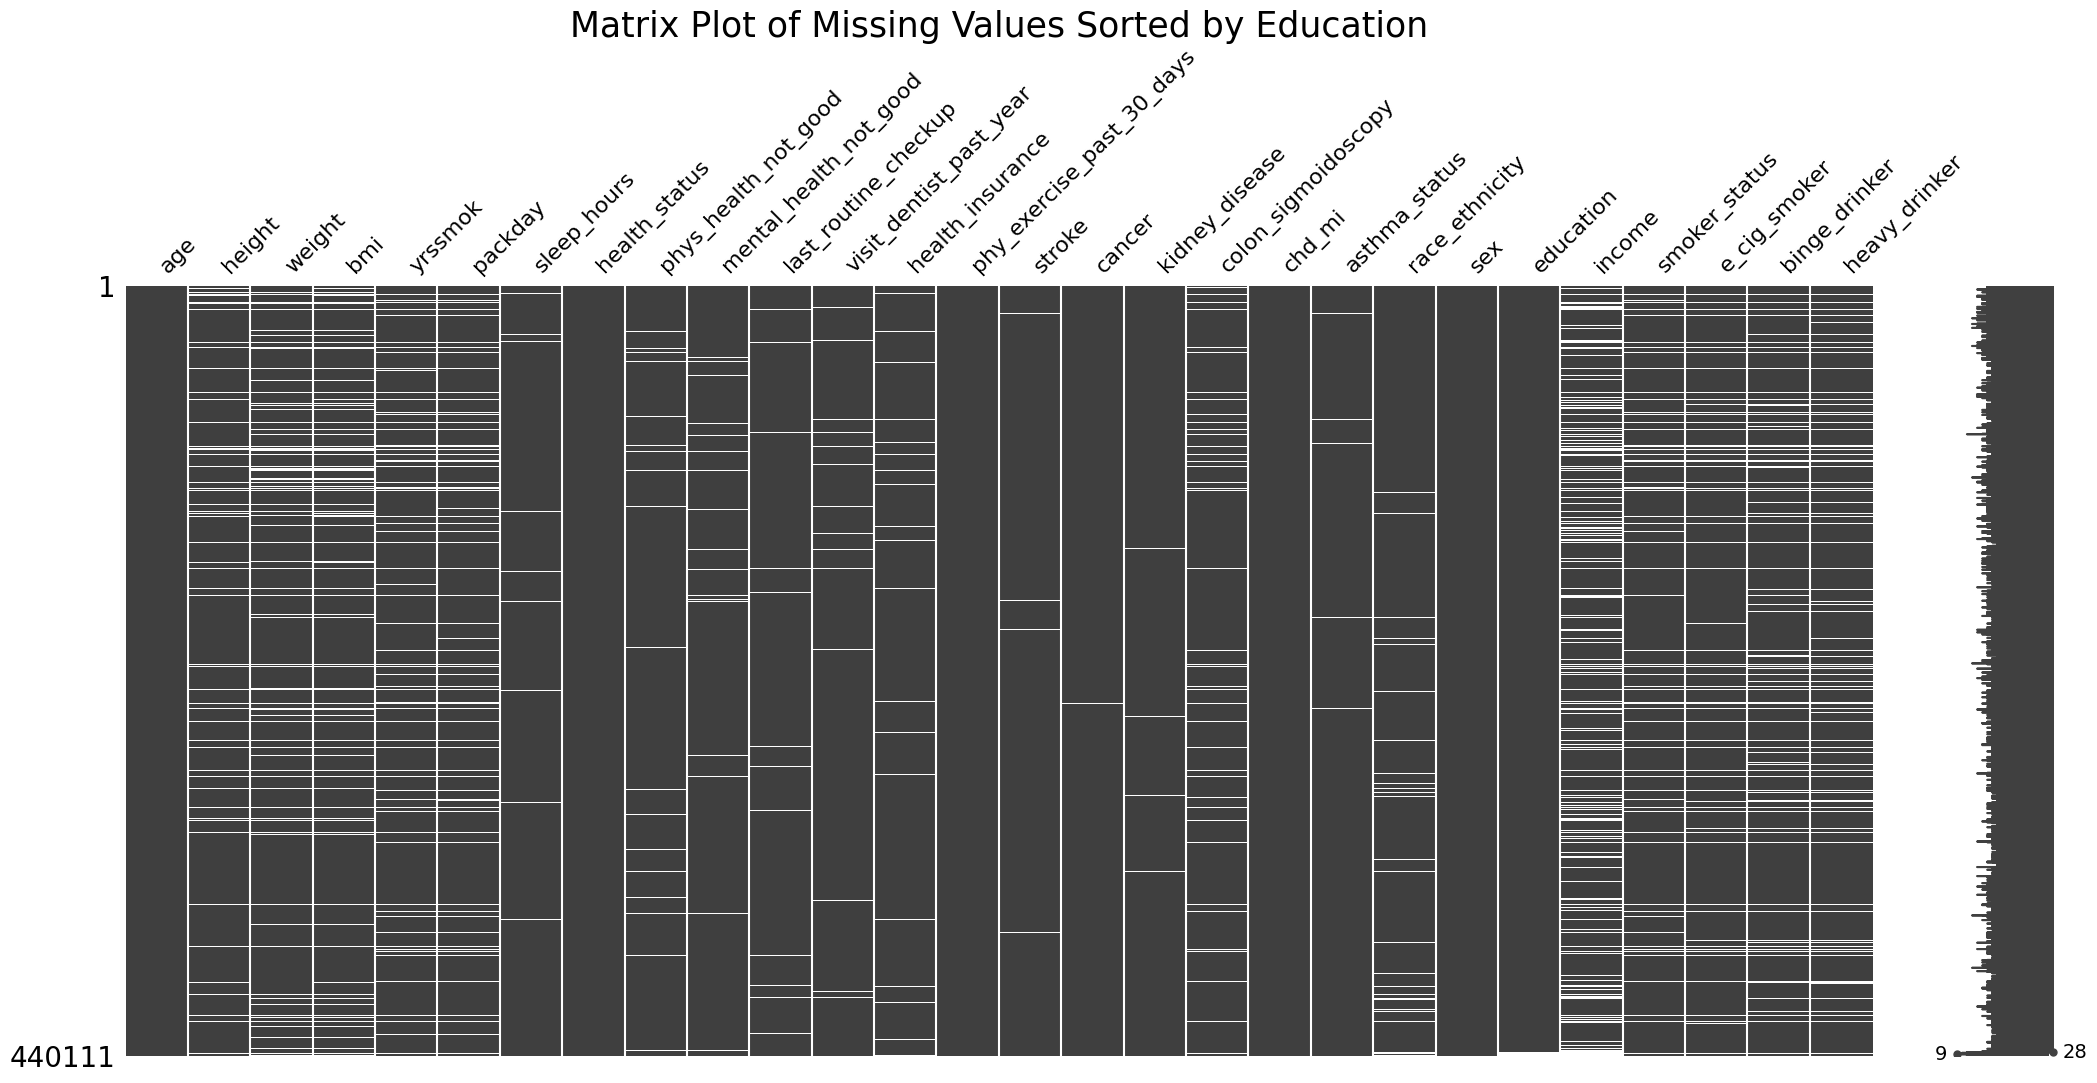

In [ ]:
# Visualise missing values using a matrix plot sorted by education
msno.matrix(df.sort_values('education'))
plt.title('Matrix Plot of Missing Values Sorted by Education', fontsize=25)

Very similar pattern of missingness observed in the above 4 matrix plots as compared in 2.3.1. Missingness in `income` still appears random.

#### 2B.3.3 Matrix plot sorted by weight

Text(0.5, 1.0, 'Matrix Plot of Missing Values Sorted by Weight')

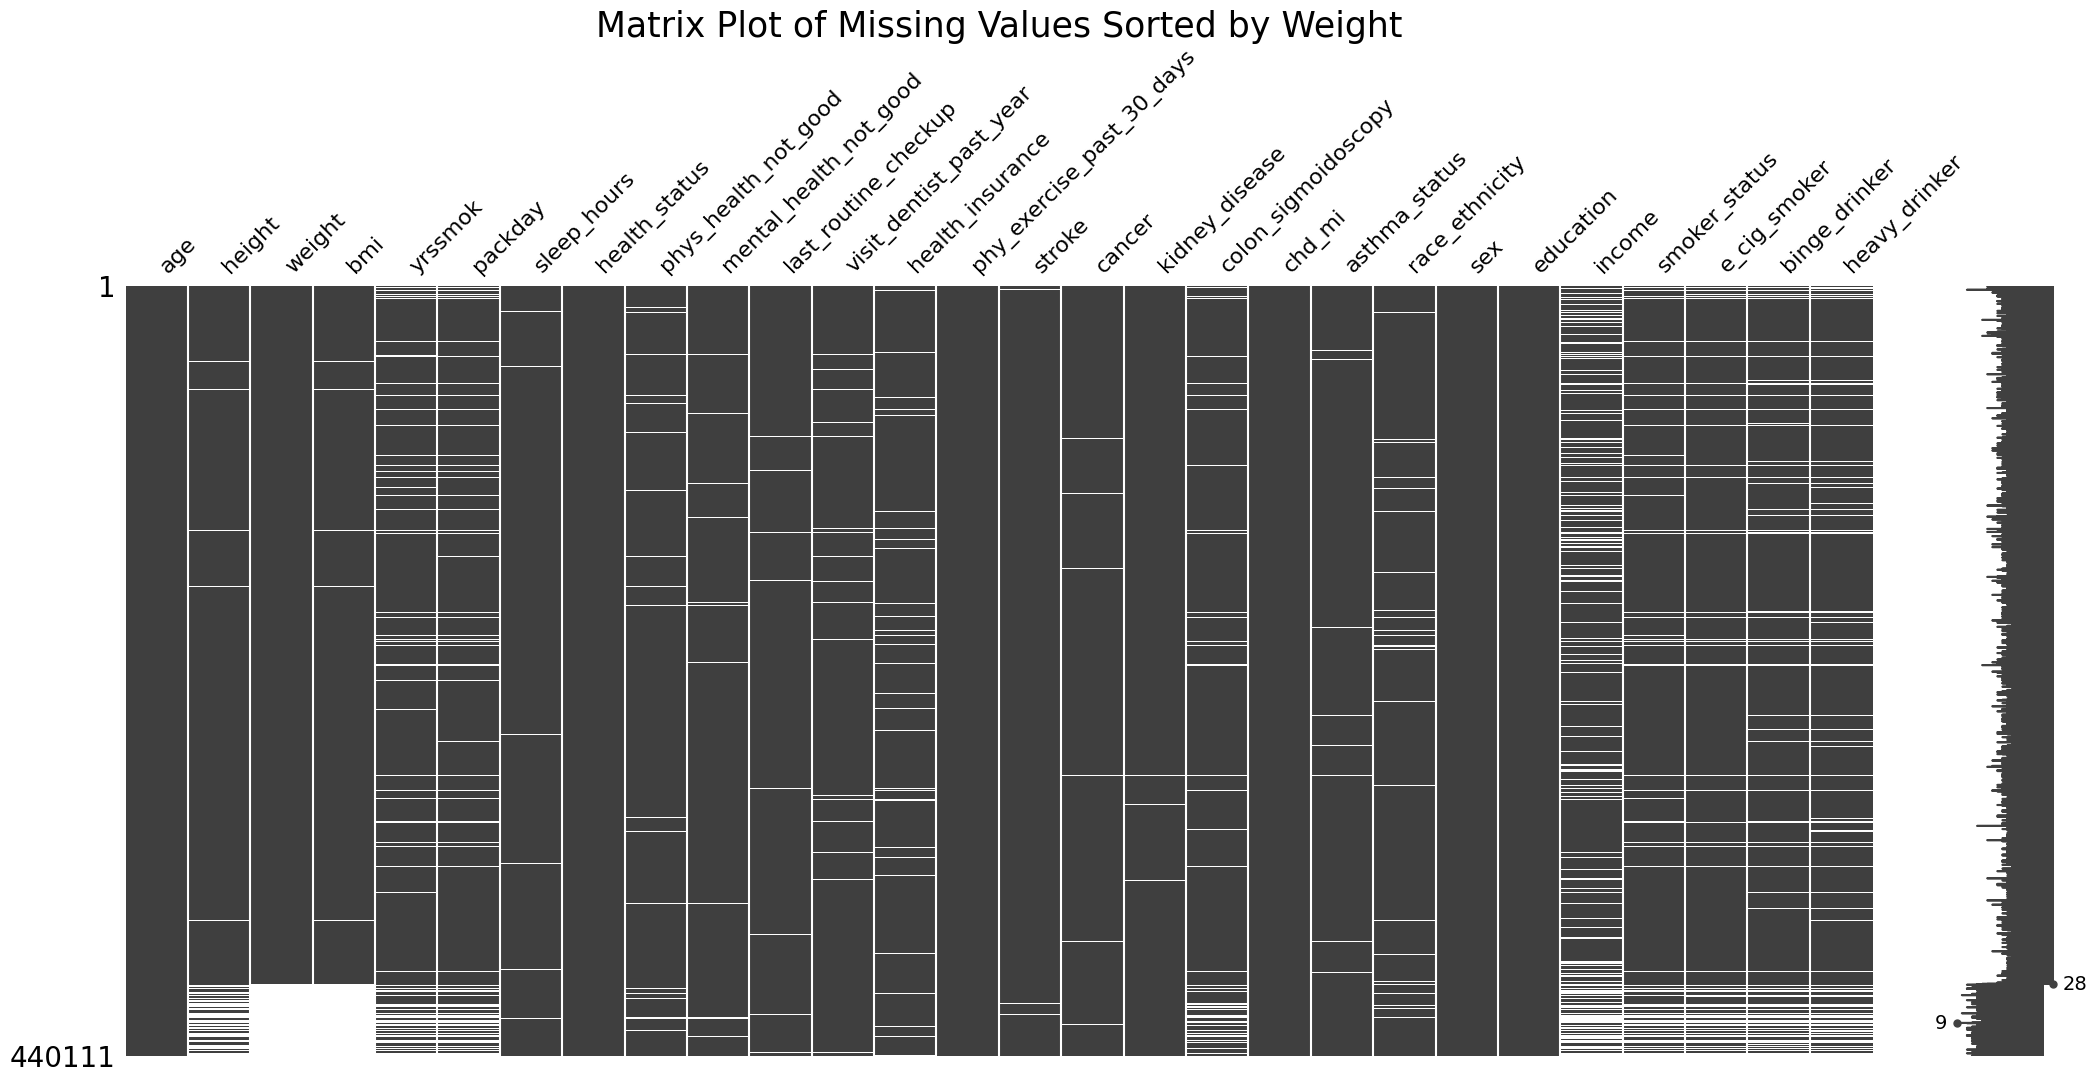

In [ ]:
# Visualise missing values using a matrix plot sorted by weight
msno.matrix(df.sort_values('weight'))
plt.title('Matrix Plot of Missing Values Sorted by Weight', fontsize=25)

Very similar pattern of missingness observed in this matrix plots as compared to the those in 2.3.1. Missingness in 'income' still appears random.  
  
Interestingly, there also seem to be a similar pattern observed for `colon_sigmoidoscopy` as compared to those in 2.3.1 as well, based on all the white lines gathered at the bottom part of the matrix. This itself might be a good topic for separate investigation.

#### 2B.3.4 Dendrogram of missing data

Text(0.5, 1.0, 'Dendrogram of Missing Values')

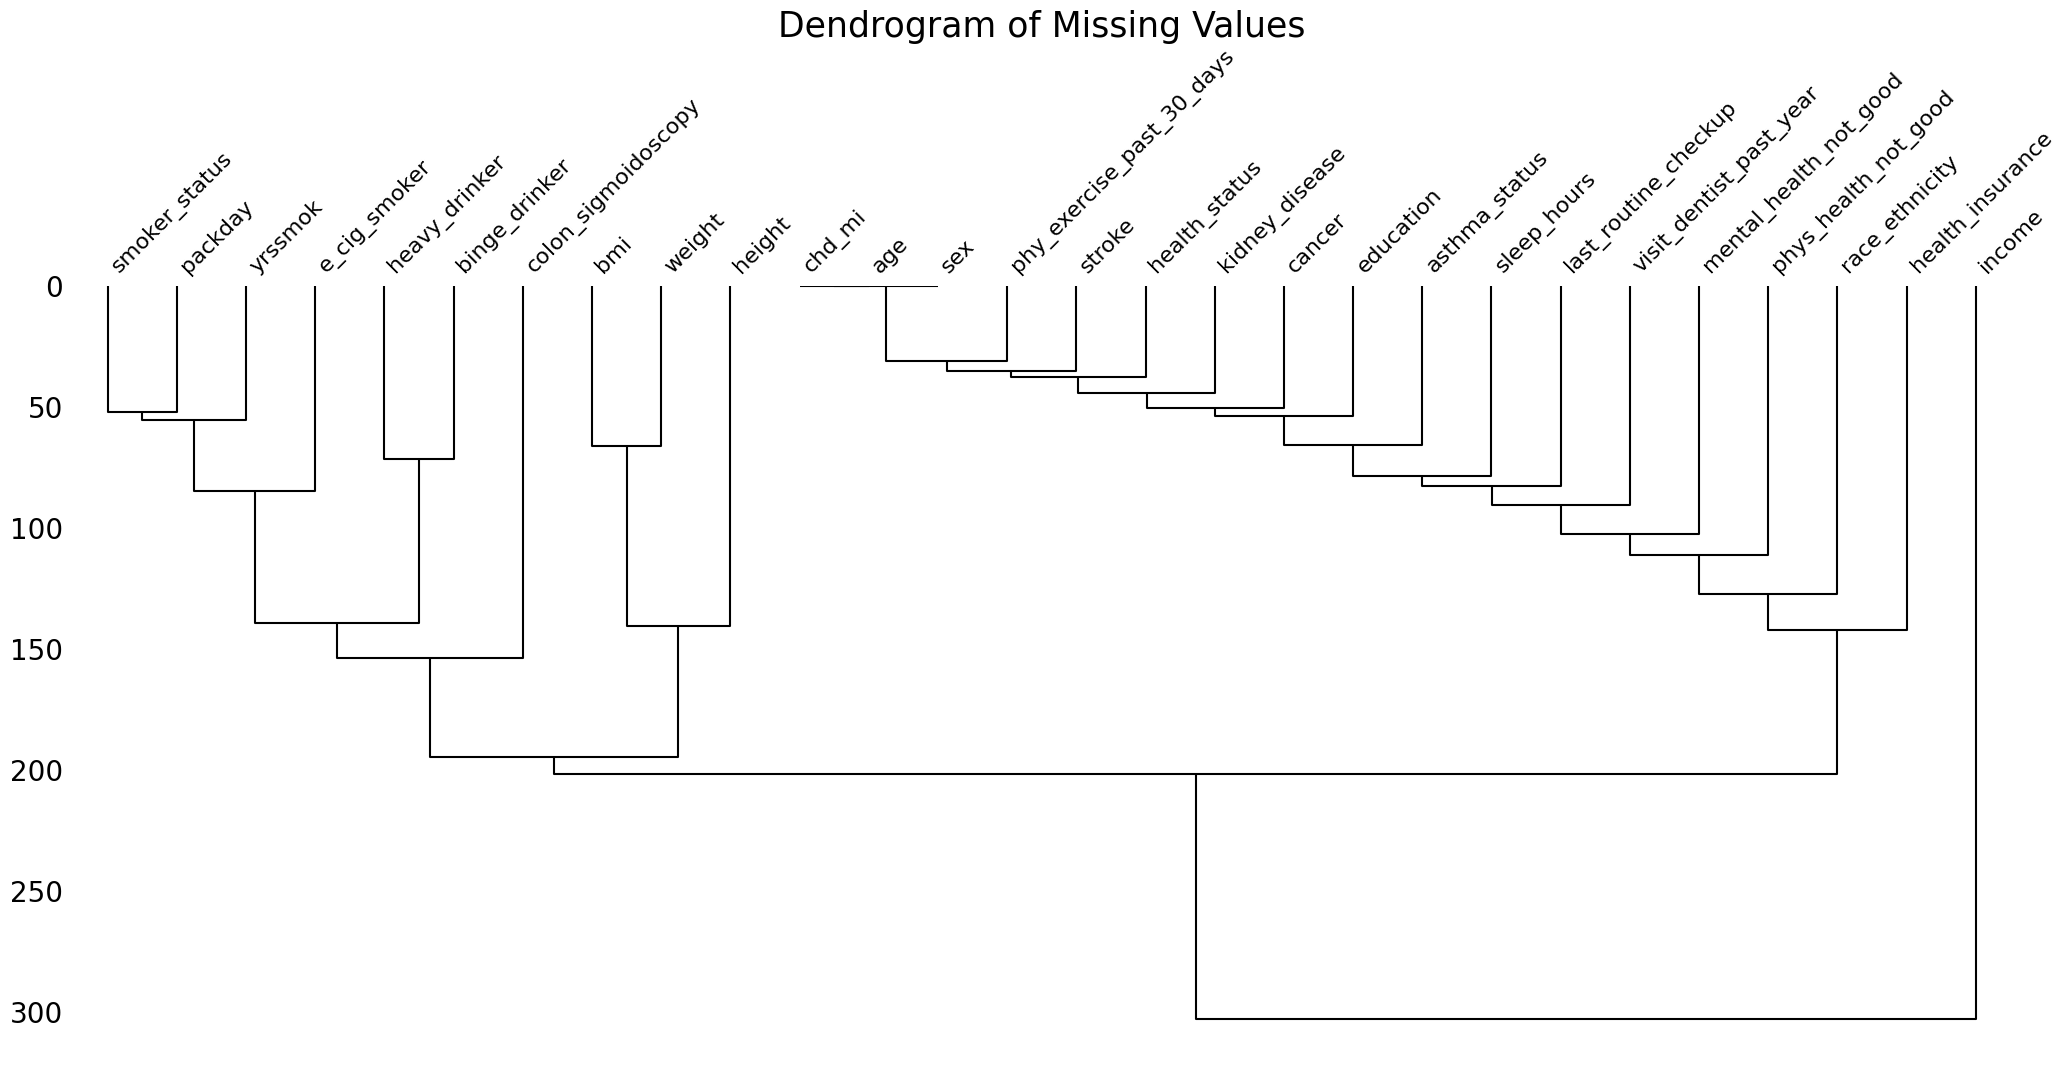

In [ ]:
# Plot a dendrogram of missingness of data
msno.dendrogram(df)
plt.title('Dendrogram of Missing Values', fontsize=25)

Interpretation:  
The dendrogram specifically focuses on visualizing correlations between missing values in different columns.  
Shorter branch lengths between columns indicate a stronger correlation in missing value patterns. These columns tend to have missing values together or not at all.  
Longer branch lengths signify weaker correlations, where missing values in one column might not necessarily correspond to missing values in another.

Analysis:  
  
From the left side of the dendrogram, we can identify correlations among the following clusters based on the shorter branch lengths:
1. Tobacco use: `yrssmok`, `packday`, `smoker_status`, `e_cig_smoker`
2. Alcohol consumption: `binge_drinker`, `heavy_drinker`
3. Body measurements: `height`, `weight`, `bmi`  
  
There is not much pattern for the right side of the dendrogram as we do not see any clear clustering.  
  
Amongst all, missingness of income information is not related to any other columns as it has the longest branch.

#### 2B.3.5 Analysis of missingness mechanism

1. Based on the above matrix plots and dendrogram, we can conclude that the following variables are closely related to each other, as they are clustered into a single large group on the left side of the plot:  

    1. Body measurements: `height`, `weight`, `bmi`,
    2. Tobacco use: `yrssmok`, `packday`, `smoker_status`, `e_cig_smoker`, and
    3. Alcohol consumption: `binge_drinker`, `heavy_drinker`,   
  
  We will classify these variables as Missing Not At Random (MNAR), where the probability of missing data is related to the missing values themselves. In this case, respondents who might be unwilling to disclose sensitive information like the above might be more likely to not answer these questions.

2. Income has the highest proportion of null values (21.58%). Based on the matrix plots, the missingness of the data does not seem to have any relationship with any other variable. With reference to the dendrogram, it shows up a cluster on its own on the right side of the plot.  
  
    Due to the sensitive nature of revealing income details, we will classify this as Missing At Random (MAR).

### 2B.4 Imputing missing values using KNN Imputer

We will use KNN Imputer to impute null values for numerical data. It uses the K-Nearest Neighbours algorithm, which takes the mean of the nearest k neighbours. KNNImputer can impute missing values in multivariate datasets where missingness occurs multiple variables, and more than one column is used to fill the missing values.

In [ ]:
# Select numerical variables and keep the target variable
X_num = df[['age', 'height', 'weight', 'bmi', 'yrssmok', 'packday', 'sleep_hours', 'chd_mi']]
X_num.columns

Index(['age', 'height', 'weight', 'bmi', 'yrssmok', 'packday', 'sleep_hours', 'chd_mi'], dtype='object')

#### 2B.4.1 KNN Imputer with k = 3, 5 and 7

In [ ]:
%%time

# KNN Imputer with hyperparameter (n_neighbors) set to 3

# Initialize
knn_imp_3 = KNNImputer(n_neighbors=3)

# Fit/transform
X_num_imp_3 = knn_imp_3.fit_transform(X_num)
X_num_imp_3_df = pd.DataFrame(X_num_imp_3, columns=X_num.columns)

CPU times: user 40min 11s, sys: 16min 26s, total: 56min 37s
Wall time: 36min 13s


In [ ]:
%%time

# KNN Imputer with hyperparameter (n_neighbors) set to 5

# Initialize
knn_imp_5 = KNNImputer(n_neighbors=5)

# Fit/transform
X_num_imp_5 = knn_imp_5.fit_transform(X_num)
X_num_imp_5_df = pd.DataFrame(X_num_imp_5, columns=X_num.columns)

CPU times: user 30min 2s, sys: 16min 31s, total: 46min 34s
Wall time: 26min 7s


In [ ]:
%%time

# KNN Imputer with hyperparameter (n_neighbors) set to 7

# Initialize
knn_imp_7 = KNNImputer(n_neighbors=7)

# Fit/transform
X_num_imp_7 = knn_imp_7.fit_transform(X_num)
X_num_imp_7_df = pd.DataFrame(X_num_imp_7, columns=X_num.columns)

CPU times: user 30min 3s, sys: 16min 35s, total: 46min 38s
Wall time: 26min 7s


#### 2B.4.2 Comparison of k = 3, 5 and 7

To determine the most appropriate value for k, we will use a visual approach for comparison.

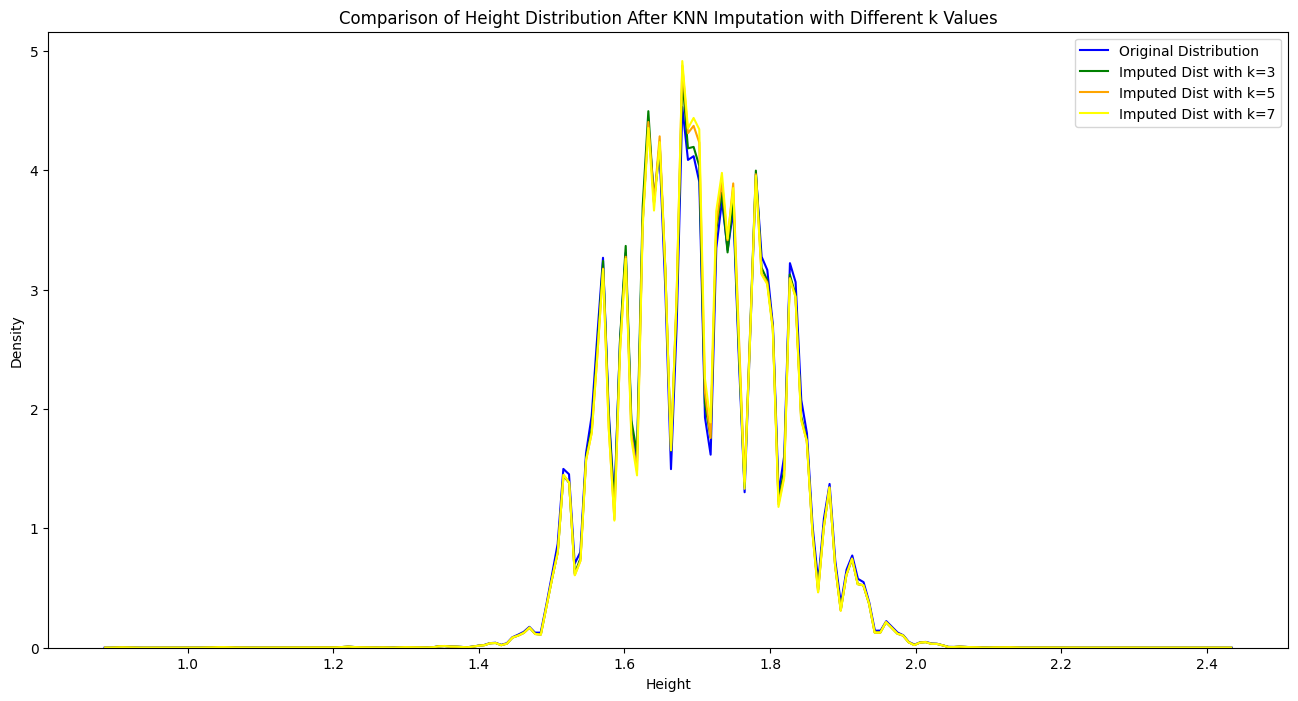

In [ ]:
# To compare across various k values and decide the most suitable one
fig, ax = plt.subplots(figsize=(16, 8))

# Plot all distributions to compare
sns.kdeplot(X_num['height'], label="Original Distribution", color='blue') # original distribution
sns.kdeplot(X_num_imp_3_df['height'], label="Imputed Dist with k=3", color='green') # with n_neighbours = 3
sns.kdeplot(X_num_imp_5_df['height'], label="Imputed Dist with k=5", color='orange') # with n_neighbours = 5
sns.kdeplot(X_num_imp_7_df['height'], label="Imputed Dist with k=7", color='yellow') # with n_neighbours = 7

# add plot info
plt.legend()
plt.xlabel('Height')
plt.ylabel('Density')
plt.title('Comparison of Height Distribution After KNN Imputation with Different k Values')

plt.show()

Analysis:  
Based on the above plot, it appears that k=5 is the most appropriate value as its distribution is more similar to the original dataset.

#### 2B.4.3 Comparison of summary statistics

In [ ]:
# Summary statistics for original dataset
X_num.describe()

,age,height,weight,bmi,yrssmok,packday,sleep_hours,chd_mi
count,440111.000000,412123.000000,398865.000000,394479.000000,402029.000000,402638.000000,434998.000000,440111.000000
mean,54.808039,1.702805,83.074360,28.526302,3.982422,0.077723,7.023412,1.909680
std,17.697395,0.107141,21.425866,6.599558,12.272219,0.282425,1.495109,0.286641
min,18.000000,0.910000,22.680000,6.770000,0.000000,0.000000,1.000000,1.000000
25%,41.000000,1.630000,68.040000,24.110000,0.000000,0.000000,6.000000,2.000000
50%,57.000000,1.700000,80.740000,27.350000,0.000000,0.000000,7.000000,2.000000
75%,70.000000,1.780000,95.250000,31.760000,0.000000,0.000000,8.000000,2.000000
max,80.000000,2.410000,292.570000,235.530000,97.000000,15.000000,24.000000,2.000000


In [ ]:
# Summary statistics for imputed - KNN k=5
X_num_imp_5_df.describe()

,age,height,weight,bmi,yrssmok,packday,sleep_hours,chd_mi
count,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000
mean,54.808039,1.702654,82.965179,28.548982,3.958385,0.077640,7.024529,1.909680
std,17.697395,0.104449,20.684326,6.368826,11.895057,0.273689,1.488678,0.286641
min,18.000000,0.910000,22.680000,6.770000,0.000000,0.000000,1.000000,1.000000
25%,41.000000,1.630000,68.040000,24.340000,0.000000,0.000000,6.000000,2.000000
50%,57.000000,1.700000,80.740000,27.490000,0.000000,0.000000,7.000000,2.000000
75%,70.000000,1.780000,93.348000,31.505000,0.000000,0.000000,8.000000,2.000000
max,80.000000,2.410000,292.570000,235.530000,97.000000,15.000000,24.000000,2.000000


Analysis:

Comparing both the original and the imputed dataset of `n_neighbors = 5` we can see that the means and standard deviations are very similar between them.

Both the minimum and maximum values are identical.

#### 2B.4.4 Comparison of distribution

We want to evaluate if there is any significant change in the distribution of the variables before and after imputing null values. We will use the columns with more than 5% of null values to do that.

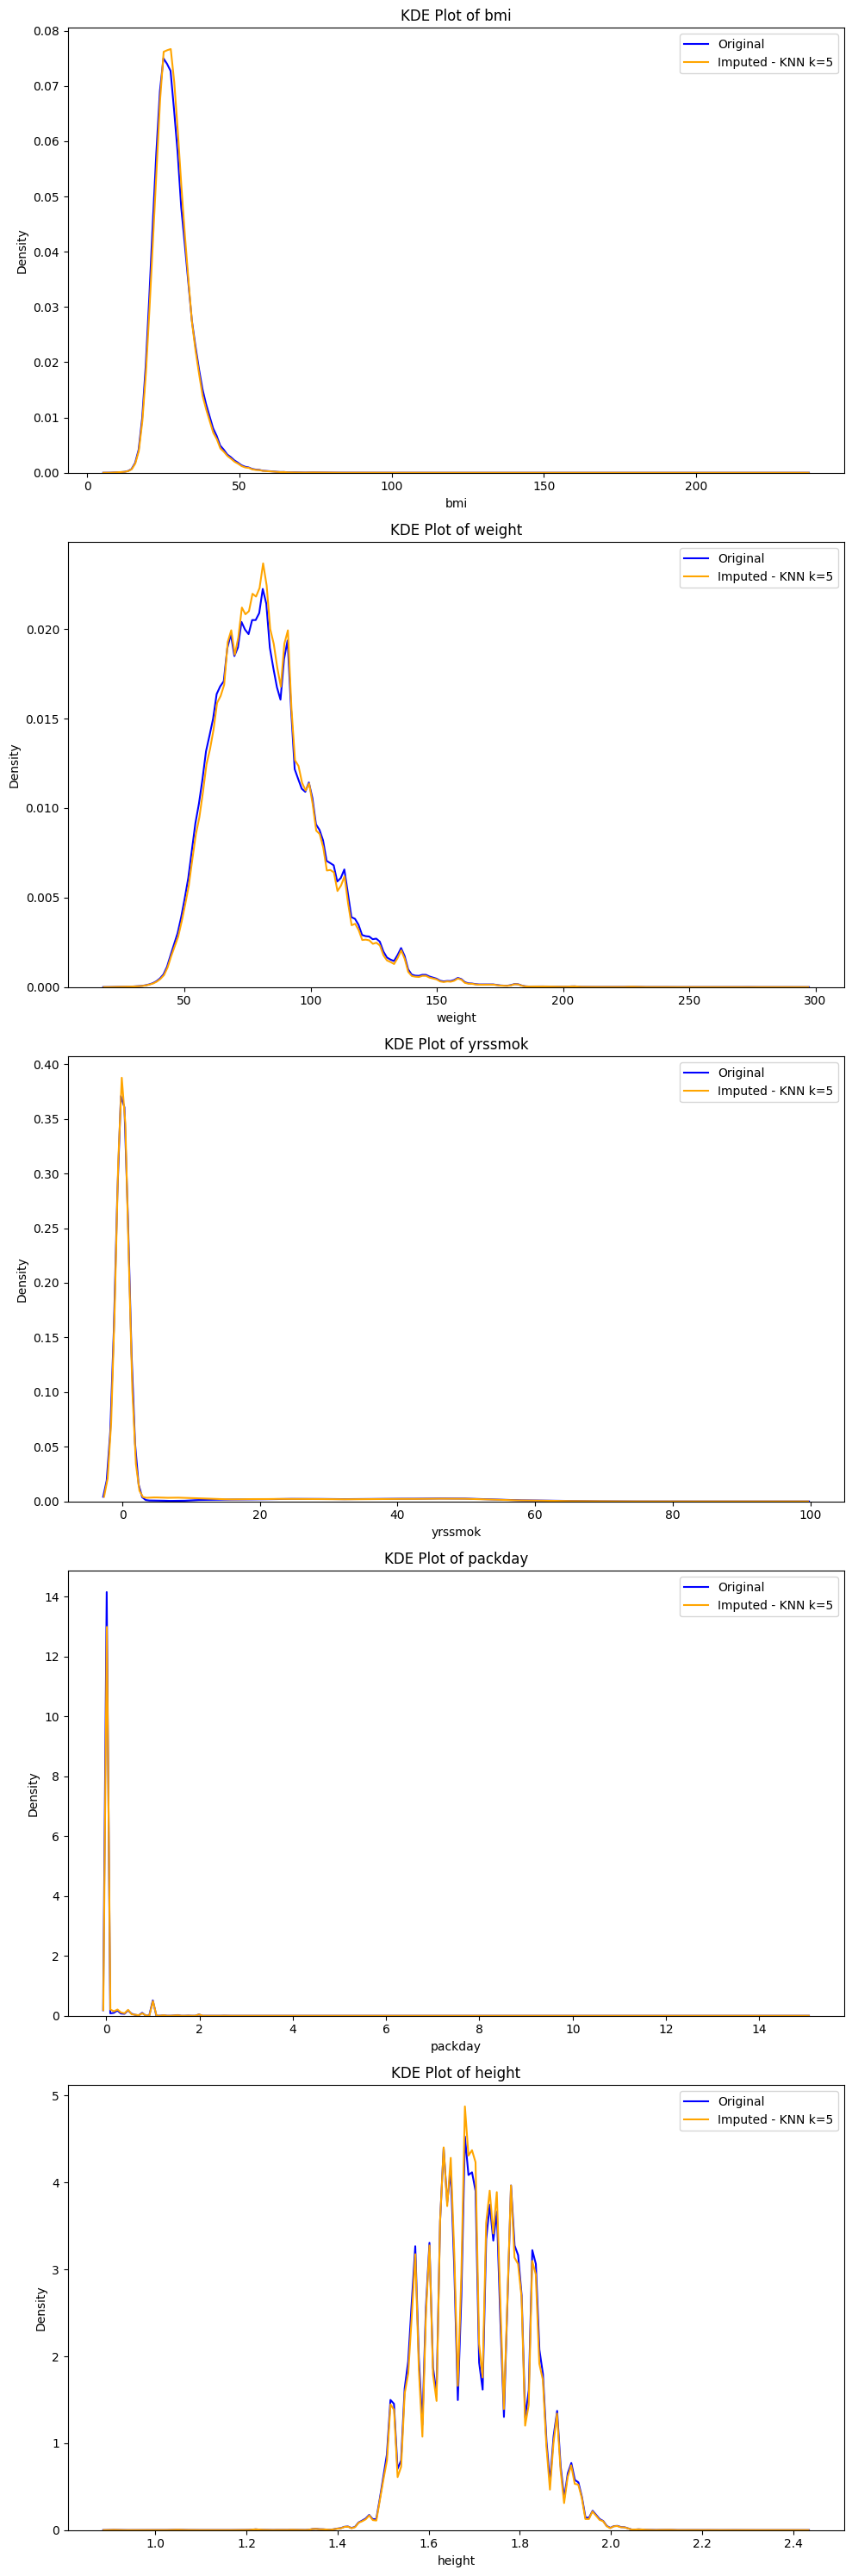

In [ ]:
# to sort the number of mean in their proportion while having the largest value shown at the top in descending order
X_num_nulls = X_num.isnull().mean().sort_values(ascending=False)

# filter out the variables that have more than 5% null values
high_null_num = X_num_nulls[X_num_nulls>0.05]
high_null_num_list = high_null_num.index.to_list() # list the columns

X = df.copy()

X_selected = X[high_null_num_list]
X_num_imp_5_df_selected = X_num_imp_5_df[high_null_num_list]

# Create subplots for KDE plots
fig, axes = plt.subplots(nrows=len(high_null_num_list), ncols=1, figsize=(10, 30))

# Plot KDE plots for each pair of corresponding columns
for i, column in enumerate(high_null_num_list):
    sns.kdeplot(X_selected[column], ax=axes[i], color='blue', label='Original')
    sns.kdeplot(X_num_imp_5_df_selected[column], ax=axes[i], color='orange', label='Imputed - KNN k=5')
    axes[i].set_title(f'KDE Plot of {column}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Analysis:

Overall, KNN imputation has subtly altered the distributions, typically reducing the severity of peaks and filling in data gaps, which suggests a more uniform spread of values. Moreover, the overall structure and central tendencies of the distributions are largely preserved, indicating that the imputed values are in line with the existing patterns in the data.

### 2B.5 Imputing missing values using Missing Forest

Missing Forest (MissForest) is a technique which uses a Random Forest algorithm. It is particularly well-suited for multiple imputation of datasets with mixed data types (numerical and categorical), just like our current dataset. It utilizes ensembles of decision trees to predict missing values based on the observed data. MissForest operates by isolating observations with similar characteristics and imputing missing values within those groups using values from similar observations. This approach offers robustness to outliers and non-linear relationships between features, potentially leading to more accurate imputations compared to traditional methods.

In [ ]:
# List of categorical variables
# we will keep both 'age' and target variable for the imputation
X_cat = df.drop(columns=['height', 'weight', 'bmi', 'yrssmok', 'packday', 'sleep_hours']) # drop numerical columns
cat_col = X_cat.columns
print(cat_col)

Index(['age', 'health_status', 'phys_health_not_good', 'mental_health_not_good', 'last_routine_checkup', 'visit_dentist_past_year', 'health_insurance', 'phy_exercise_past_30_days', 'stroke', 'cancer', 'kidney_disease', 'colon_sigmoidoscopy', 'chd_mi', 'asthma_status', 'race_ethnicity', 'sex', 'education', 'income', 'smoker_status', 'e_cig_smoker', 'binge_drinker', 'heavy_drinker'], dtype='object')


#### 2B.5.1 Missing Forest

In [ ]:
# Instantiate the imputer with max of 10 iterations
imputer_mixed = MissForest(max_iter=10)

In [ ]:
# # Create a copy of the original dataframe
# X = df.copy()

# print(X.columns)

Index(['age', 'height', 'weight', 'bmi', 'yrssmok', 'packday', 'sleep_hours', 'health_status', 'phys_health_not_good', 'mental_health_not_good', 'last_routine_checkup', 'visit_dentist_past_year', 'health_insurance', 'phy_exercise_past_30_days', 'stroke', 'cancer', 'kidney_disease', 'colon_sigmoidoscopy', 'chd_mi', 'asthma_status', 'race_ethnicity', 'sex', 'education', 'income', 'smoker_status', 'e_cig_smoker', 'binge_drinker', 'heavy_drinker'], dtype='object')


In [ ]:
%%time

# create a copy of the dataframe being used
X_cat = X_cat.copy()

# Fit and transform X, specify categorical variables
X_imputed_mixed = imputer_mixed.fit_transform(X_cat, categorical=cat_col)

/opt/anaconda3/envs/GA-env/lib/python3.12/site-packages/missforest/missforest.py:227: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x[c].fillna(initial_imputations[c], inplace=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 285421, number of used features: 21
[LightGBM] [Info] Start training from score -1.036817
[LightGBM] [Info] Start training from score -1.806267
[LightGBM] [Info] Start training from score -2.079039
[LightGBM] [Info] Start training from score -3.262545
[LightGBM] [Info] Start training from score -1.146298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 285421, number of used features: 21
[LightGBM] [Info] Start 

#### 2B.5.2 Comparison of summary statistics

In [ ]:
# Summary statistics for original dataset
X.describe()

,age,height,weight,bmi,yrssmok,packday,sleep_hours,health_status,phys_health_not_good,mental_health_not_good,last_routine_checkup,visit_dentist_past_year,health_insurance,phy_exercise_past_30_days,stroke,cancer,kidney_disease,colon_sigmoidoscopy,chd_mi,asthma_status,race_ethnicity,sex,education,income,smoker_status,e_cig_smoker,binge_drinker,heavy_drinker
count,440111.000000,412123.000000,398865.000000,394479.000000,402029.000000,402638.000000,434998.000000,439048.000000,429668.000000,431425.000000,434592.000000,433435.000000,422779.000000,439150.000000,439086.000000,438125.000000,438590.000000,418527.000000,440111.000000,436677.000000,426492.000000,440111.000000,437949.00000,345976.000000,405339.000000,405134.000000,389945.000000,391320.00000
mean,54.808039,1.702805,83.074360,28.526302,3.982422,0.077723,7.023412,2.559255,1.513818,1.529040,1.379259,1.331129,1.053638,1.238197,1.957473,1.887009,1.954639,318.529961,1.909680,2.751065,2.057288,1.530457,3.06456,6.852634,3.392383,1.054140,1.144992,1.06671
std,17.697395,0.107141,21.425866,6.599558,12.272219,0.282425,1.495109,1.049493,0.717049,0.723927,0.920506,0.470620,0.225302,0.425980,0.201788,0.316582,0.208095,464.641149,0.286641,0.626865,2.249719,0.499072,0.94716,2.445979,0.911725,0.226294,0.352093,0.24952
min,18.000000,0.910000,22.680000,6.770000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,41.000000,1.630000,68.040000,24.110000,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.00000,5.000000,3.000000,1.000000,1.000000,1.00000
50%,57.000000,1.700000,80.740000,27.350000,0.000000,0.000000,7.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,1.000000,2.000000,3.00000,7.000000,4.000000,1.000000,1.000000,1.00000
75%,70.000000,1.780000,95.250000,31.760000,0.000000,0.000000,8.000000,3.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,999.000000,2.000000,3.000000,2.000000,2.000000,4.00000,9.000000,4.000000,1.000000,1.000000,1.00000
max,80.000000,2.410000,292.570000,235.530000,97.000000,15.000000,24.000000,5.000000,3.000000,3.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,999.000000,2.000000,3.000000,8.000000,2.000000,4.00000,11.000000,4.000000,2.000000,2.000000,2.00000


In [ ]:
# Summary statistics for imputed - MissForest
X_imputed_mixed.describe()

,age,health_status,phys_health_not_good,mental_health_not_good,last_routine_checkup,visit_dentist_past_year,health_insurance,phy_exercise_past_30_days,stroke,cancer,kidney_disease,colon_sigmoidoscopy,chd_mi,asthma_status,race_ethnicity,sex,education,income,smoker_status,e_cig_smoker,binge_drinker,heavy_drinker
count,440111.000000,440111.000000,440111.00000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.000000,440111.00000,440111.000000,440111.000000,440111.000000,440111.000000
mean,54.808039,2.560288,1.51305,1.524615,1.376335,1.330817,1.052269,1.238044,1.957572,1.887512,1.954793,302.967440,1.909680,2.752953,2.032115,1.530457,3.065865,6.83937,3.429380,1.049867,1.130383,1.059733
std,17.697395,1.049349,0.71915,0.723272,0.918809,0.470508,0.222568,0.425887,0.201564,0.315966,0.207758,458.257418,0.286641,0.624864,2.230494,0.499072,0.947465,2.34393,0.894316,0.217670,0.336725,0.236991
min,18.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
25%,41.000000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000,5.00000,3.000000,1.000000,1.000000,1.000000
50%,57.000000,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,1.000000,2.000000,3.000000,7.00000,4.000000,1.000000,1.000000,1.000000
75%,70.000000,3.000000,2.00000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,999.000000,2.000000,3.000000,1.000000,2.000000,4.000000,9.00000,4.000000,1.000000,1.000000,1.000000
max,80.000000,5.000000,3.00000,3.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,999.000000,2.000000,3.000000,8.000000,2.000000,4.000000,11.00000,4.000000,2.000000,2.000000,2.000000


Analysis:

Comparing the imputed dataframe to the original, the means and standard deviations are largely similar for the categorical variables; the minimum and maximum for both dataframes are identical.

However, there are some differences between the income as the mean and standard deviation is higher in the imputed dataframe.


#### 2B.6 Combining numerical and categorical imputed data

In [ ]:
# As the numerical variables were imputed by KNN Imputer and categorical variables were imputed by MissForest,
# we will have to combine those dataframes that was imputed.

# obtain the columns from the numerical variables
X_num_list = X_num.columns.to_list()
print(X_num_list) # debug

['age', 'height', 'weight', 'bmi', 'yrssmok', 'packday', 'sleep_hours', 'chd_mi']


In [ ]:
print(X_imputed_mixed.columns)

Index(['age', 'health_status', 'phys_health_not_good', 'mental_health_not_good', 'last_routine_checkup', 'visit_dentist_past_year', 'health_insurance', 'phy_exercise_past_30_days', 'stroke', 'cancer', 'kidney_disease', 'colon_sigmoidoscopy', 'chd_mi', 'asthma_status', 'race_ethnicity', 'sex', 'education', 'income', 'smoker_status', 'e_cig_smoker', 'binge_drinker', 'heavy_drinker'], dtype='object')


In [ ]:
# Using the categorical dataframe that was imputed with MissForest, we will drop the common variables
# to prepare the dataframe for the merge

X_impute = X_imputed_mixed.drop(columns = ['age', 'chd_mi'])

In [ ]:
print(X_num_imp_5_df.head())
print(X_impute.head())

    age  height  weight     bmi  yrssmok  packday  sleep_hours  chd_mi
0  80.0   1.614  72.664  26.888      0.0      0.0          8.0     2.0
1  80.0   1.600  68.040  26.580      0.0      0.0          6.0     2.0
2  56.0   1.570  63.500  25.760      0.0      0.0          5.0     2.0
3  73.0   1.650  63.500  23.320     56.0      0.1          7.0     2.0
4  43.0   1.570  53.980  21.900      0.0      0.0          9.0     2.0
   health_status  phys_health_not_good  mental_health_not_good  last_routine_checkup  visit_dentist_past_year  health_insurance  phy_exercise_past_30_days  stroke  cancer  kidney_disease  colon_sigmoidoscopy  asthma_status  race_ethnicity  sex  education  income  smoker_status  e_cig_smoker  binge_drinker  heavy_drinker
0            2.0                   1.0                     1.0                   1.0                      1.0               1.0                        2.0     2.0     2.0             2.0                  1.0            3.0             1.0  2.0        4

In [ ]:
# merge the numerical and categorical dataframe with the target label.

num_var = X_impute.reset_index(drop=True) # reset index for df that has imputed numerical values

cat_var = X_num_imp_5_df.reset_index(drop=True) # reset index for df that has imputed categorical values

imputed_combined = pd.concat([cat_var, num_var], axis = 1) # to combine altogether


In [ ]:
print(f'''

The dataset started with {df.shape[0]} rows and {df.shape[1]} columns.
After imputing, the the final dataset consists of {imputed_combined.shape[0]} and {imputed_combined.shape[1]} columns.

''')



The dataset started with 440111 rows and 28 columns.
After imputing, the the final dataset consists of 440111 and 28 columns. 




In [ ]:
# final check that there is no null values
print(imputed_combined.isna().sum())

age                          0
height                       0
weight                       0
bmi                          0
yrssmok                      0
packday                      0
sleep_hours                  0
chd_mi                       0
health_status                0
phys_health_not_good         0
mental_health_not_good       0
last_routine_checkup         0
visit_dentist_past_year      0
health_insurance             0
phy_exercise_past_30_days    0
stroke                       0
cancer                       0
kidney_disease               0
colon_sigmoidoscopy          0
asthma_status                0
race_ethnicity               0
sex                          0
education                    0
income                       0
smoker_status                0
e_cig_smoker                 0
binge_drinker                0
heavy_drinker                0
dtype: int64


### 2B.7 Export of Dataset

In [ ]:
# export final dataset into csv

imputed_combined.to_csv('../data/final_dataset.csv', index=False)

### 2B.8 Key Takeaways

Since our dataset deals with health information, it naturally has a fair amount of missing data. We've uncovered patterns in how these values are missing for certain variables and used techniques to fill in those gaps. In the next notebook [2C. Exploratory Data Analysis - Before and After Imputation](02C_EDA_Before_and_After_Imputation.ipynb), we'll be looking at specific columns to see if the distribution of the data has changed after filling in the missing values. This will help us understand the impact of imputation on our data.